In [1]:
import torch as t
import torch.nn.functional as F
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torchvision import transforms

import utils
from dataset import CasiaWebFaceDataset, LFWDataset, LFWGFPGANDataset
from models.pfe import PFE
from models.proxyanchor import ProxyAnchor

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [2]:
batch_size = 16
batch_classes = 4
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
device = 'cuda:3'

pfe_cfg = OmegaConf.load('config/pfe/experiment.yaml')
proxyanchor_cfg = OmegaConf.load('config/proxyanchor/experiment.yaml')
proxype_cfg = OmegaConf.load('config/proxype/experiment.yaml')

pfe_ckpt = 'ckpt/pfe/2023-12-05_22.05.16_pfe_lfw-only_0.016_0.012_599_h1.pth'
proxyanchor_ckpt = 'ckpt/proxyanchor/2023-12-04_10.13.55_proxyanchor_lfw-only_0.307_0.180_599_g0.pth'
proxype_ckpt = 'ckpt/proxype/2023-12-05_19.15.46_proxype_lfw-only_0.127_0.080_599_h2.pth'

pfe_gfpgan_ckpt = 'ckpt/pfe/2023-12-11_08.36.44_pfe_lfw-gfpgan-only_0.007_0.003_599_hgfp0.pth'
proxyanchor_gfpgan_ckpt = 'ckpt/proxyanchor/2023-12-11_17.48.22_proxyanchor_lfw-gfpgan-only_0.299_0.172_599_ggfp0.pth'
proxype_gfpgan_ckpt = 'ckpt/proxype/2023-12-11_13.31.01_proxype_lfw-gfpgan-only_0.128_0.079_599_hgfp2.pth'

In [6]:
# RUN THIS CELL AT LEAST TWICE!

lfw_tst_set = LFWDataset(
    split='test',
    image_set='original',
    transform=utils.make_transform(train=False),
    download=True
)
lfw_unnormalized_tst_set = LFWDataset(
    split='test',
    image_set='original',
    transform=transform,
    download=True
)
lfw_gfpgan_tst_set = LFWGFPGANDataset(
    split='test',
    image_set='deepfunneled',
    transform=utils.make_transform(train=False),
    download=True
)
lfw_gfpgan_unnormalized_tst_set = LFWGFPGANDataset(
    split='test',
    image_set='deepfunneled',
    transform=transform,
    download=True
)
# casia_trn_set = CasiaWebFaceDataset(
#     transform=utils.make_transform(train=True)
# )
# casia_tst_set = LFWDataset(
#     split='10fold',
#     image_set='original',
#     transform=transform,
#     download=True
# )

lfw_num_classes = lfw_tst_set.num_classes()
lfw_gfpgan_num_classes = lfw_gfpgan_tst_set.num_classes()
# casia_num_classes = casia_trn_set.num_classes()

lfw_tst_loader = DataLoader(
    lfw_tst_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

lfw_unnormalized_tst_loader = DataLoader(
    lfw_unnormalized_tst_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

lfw_gfpgan_tst_loader = DataLoader(
    lfw_gfpgan_tst_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
lfw_gfpgan_unnormalized_tst_loader = DataLoader(
    lfw_gfpgan_unnormalized_tst_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# casia_trn_balanced_sampler = BalancedSampler(
#     casia_trn_set,
#     batch_size=batch_size,
#     batch_classes=batch_classes
# )
# casia_trn_batch_sampler = BatchSampler(
#     casia_trn_balanced_sampler,
#     batch_size=batch_size,
#     drop_last=True
# )

# casia_trn_loader = DataLoader(
#     casia_trn_set,
#     num_workers=1,
#     pin_memory=True,
#     batch_sampler=casia_trn_batch_sampler
# )
# casia_tst_loader = DataLoader(
#     casia_tst_set,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=1,
#     pin_memory=True
# )


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
pfe_model = PFE(
    emb_size=pfe_cfg.model.emb_size,
    use_pretrained=pfe_cfg.model.use_pretrained,
    use_l2norm=pfe_cfg.model.use_l2norm,
    freeze_bnorm=pfe_cfg.model.freeze_bnorm,
    freeze_backbone=pfe_cfg.model.freeze_backbone,
    uncertainty_fc_size=pfe_cfg.model.uncertainty_fc_size
).to(device)
pfe_gfpgan_model = PFE(
    emb_size=pfe_cfg.model.emb_size,
    use_pretrained=pfe_cfg.model.use_pretrained,
    use_l2norm=pfe_cfg.model.use_l2norm,
    freeze_bnorm=pfe_cfg.model.freeze_bnorm,
    freeze_backbone=pfe_cfg.model.freeze_backbone,
    uncertainty_fc_size=pfe_cfg.model.uncertainty_fc_size
).to(device)

proxyanchor_model = ProxyAnchor(
    emb_size=proxyanchor_cfg.model.emb_size,
    use_pretrained=proxyanchor_cfg.model.use_pretrained,
    use_l2norm=proxyanchor_cfg.model.use_l2norm,
    freeze_bnorm=proxyanchor_cfg.model.freeze_bnorm
).to(device)
proxyanchor_gfpgan_model = ProxyAnchor(
    emb_size=proxyanchor_cfg.model.emb_size,
    use_pretrained=proxyanchor_cfg.model.use_pretrained,
    use_l2norm=proxyanchor_cfg.model.use_l2norm,
    freeze_bnorm=proxyanchor_cfg.model.freeze_bnorm
).to(device)

proxype_model = PFE(
    emb_size=proxype_cfg.model.emb_size,
    use_pretrained=proxype_cfg.model.use_pretrained,
    use_l2norm=proxype_cfg.model.use_l2norm,
    freeze_bnorm=proxype_cfg.model.freeze_bnorm,
    freeze_backbone=proxype_cfg.model.freeze_backbone,
    uncertainty_fc_size=proxype_cfg.model.uncertainty_fc_size
).to(device)
proxype_gfpgan_model = PFE(
    emb_size=proxype_cfg.model.emb_size,
    use_pretrained=proxype_cfg.model.use_pretrained,
    use_l2norm=proxype_cfg.model.use_l2norm,
    freeze_bnorm=proxype_cfg.model.freeze_bnorm,
    freeze_backbone=proxype_cfg.model.freeze_backbone,
    uncertainty_fc_size=proxype_cfg.model.uncertainty_fc_size
).to(device)


In [ ]:
pfe_ckpt = t.load(pfe_ckpt, map_location=device)
pfe_model.load_state_dict(pfe_ckpt['model_state_dict'])
pfe_model.name = 'pfe'

proxyanchor_ckpt = t.load(proxyanchor_ckpt, map_location=device)
proxyanchor_model.load_state_dict(proxyanchor_ckpt['model_state_dict'])
proxyanchor_model.name = 'proxyanchor'

proxype_ckpt = t.load(proxype_ckpt, map_location=device)
proxype_model.load_state_dict(proxype_ckpt['model_state_dict'])
proxype_model.name = 'proxype'

pfe_gfpgan_ckpt = t.load(pfe_gfpgan_ckpt, map_location=device)
pfe_gfpgan_model.load_state_dict(pfe_gfpgan_ckpt['model_state_dict'])
pfe_gfpgan_model.name = 'pfe'

proxyanchor_gfpgan_ckpt = t.load(proxyanchor_gfpgan_ckpt, map_location=device)
proxyanchor_gfpgan_model.load_state_dict(proxyanchor_gfpgan_ckpt['model_state_dict'])
proxyanchor_gfpgan_model.name = 'proxyanchor'

proxype_gfpgan_ckpt = t.load(proxype_gfpgan_ckpt, map_location=device)
proxype_gfpgan_model.load_state_dict(proxype_gfpgan_ckpt['model_state_dict'])
proxype_gfpgan_model.name = 'proxype'


In [ ]:
def eval_metrics(model, loader):
    # Set model to evaluation mode
    model.train(False)
    with t.no_grad():
      progress_bar = tqdm(enumerate(loader), total=len(loader))
      progress_bar.set_description(
          'EVALUATING'
      )
      labels = []
      if model.name == 'proxyanchor':
        embeddings = []
        for _, (x_batch, y_batch) in progress_bar:
          model_output = model(x_batch.squeeze().to(device))

          y = y_batch.squeeze().to(device)

          embeddings.append(model_output)
          labels.append(y)

        embeddings = t.cat(embeddings)  # (number of samples, embedding size)
        similarity_mat = F.linear(embeddings, embeddings).to(device)
      else:
        embeddings = [[], []]
        for _, (x_batch, y_batch) in progress_bar:
          model_output = model(x_batch.squeeze().to(device))

          y = y_batch.squeeze().to(device)

          embeddings[0].append(model_output[0])  # mu
          embeddings[1].append(model_output[1])  # sigma
          labels.append(y)

        embeddings = (t.cat(embeddings[0]), t.cat(embeddings[1]))
        similarity_mat = utils.compute_batch_mls(embeddings, embeddings, limit_memory=True)

      labels = t.cat(labels)  # (number of samples)

      sorted_similarity_mat = similarity_mat.topk(65)

      # (n, m) tensor where the tensor at index n contains the sorted indices of the most similar samples
      # with the sample at index n, excluding the similarity of a sample with itself. n = m = number of samples.
      ranked_similar_samples_indices = sorted_similarity_mat[1][:, 1:]

      ranked_similar_labels = labels[ranked_similar_samples_indices]

      recall = {}
      for k in [1, 2, 4, 8, 16, 32]:
        r_at_k = utils.compute_recall_at_k(labels, ranked_similar_labels, k)
        recall[k] = r_at_k

      map_at_r = utils.compute_map_at_r(labels, ranked_similar_labels)

      print(f'Recall@1={100.0 * recall[1]:.4f}')
      print(f'MAP@R={100.0 * map_at_r:.4f}')


In [7]:
eval_metrics(pfe_model, lfw_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:06<00:00, 37.20it/s]


Recall@1=1.5642
MAP@R=1.2180


In [8]:
eval_metrics(pfe_gfpgan_model, lfw_gfpgan_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:09<00:00, 23.24it/s]


Recall@1=0.7012
MAP@R=0.2767


In [9]:
eval_metrics(proxyanchor_model, lfw_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:07<00:00, 33.03it/s]


Recall@1=30.6904
MAP@R=17.9595


In [9]:
eval_metrics(proxyanchor_gfpgan_model, lfw_gfpgan_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:07<00:00, 30.54it/s]


Recall@1=29.8544
MAP@R=17.2034


In [11]:
eval_metrics(proxype_model, lfw_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:04<00:00, 50.96it/s]


Recall@1=12.7292
MAP@R=7.9999


In [10]:
eval_metrics(proxype_gfpgan_model, lfw_gfpgan_tst_loader)

EVALUATING: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:08<00:00, 28.35it/s]


Recall@1=12.8371
MAP@R=7.8713


In [9]:
def visualize_topk_samples(images, labels, ranked_similar_samples_indices, samples, topk=8):
  with t.no_grad():
    for sample in samples:
      plt.figure(figsize=(12, 6))
      plt.subplot(1, topk + 1, 1)
      plt.imshow(images[sample].transpose(1, 2, 0))
      plt.title(f'Label: {labels[sample]} (Query)', fontsize=8)
      plt.axis('off')
      for k in range(topk):
        plt.subplot(1, topk + 1, k + 2)
        plt.imshow(images[ranked_similar_samples_indices[sample]][k].transpose(1, 2, 0))
        truth = labels[ranked_similar_samples_indices[sample]][k] == labels[sample]
        plt.title(truth, color='green' if truth else 'red', fontsize=8)
        plt.axis('off')
      plt.show()


In [14]:
samples = np.random.choice(len(lfw_tst_set), 4)

In [15]:
model = pfe_model
loader = lfw_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  pfe_labels = []
  pfe_images = []
  pfe_embeddings = [[], []]
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    pfe_embeddings[0].append(model_output[0])  # mu
    pfe_embeddings[1].append(model_output[1])  # sig
    pfe_labels.append(y)
    pfe_images.append(x)

  pfe_embeddings = (t.cat(pfe_embeddings[0]), t.cat(pfe_embeddings[1]))
  pfe_similarity_mat = utils.compute_batch_mls(pfe_embeddings, pfe_embeddings, limit_memory=True)
  pfe_labels = t.cat(pfe_labels).cpu().numpy()
  pfe_images = t.cat(pfe_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:04<00:00, 55.22it/s]


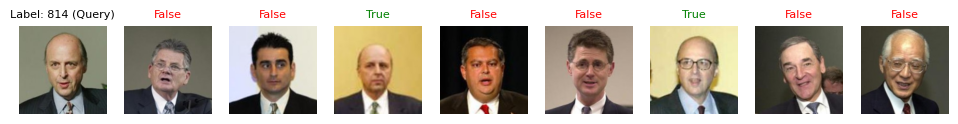

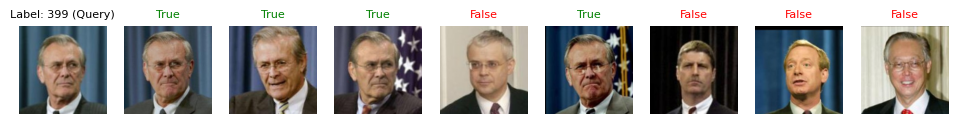

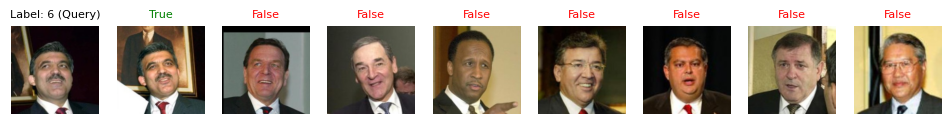

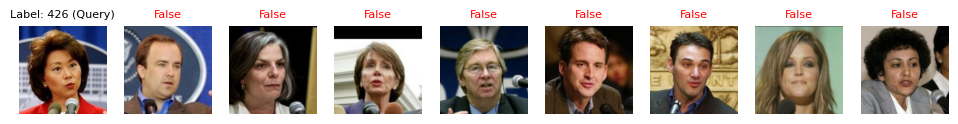

In [16]:
ranked_similar_samples_indices = pfe_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(pfe_images, pfe_labels, ranked_similar_samples_indices, samples, 8)


In [17]:
model = pfe_model
loader = lfw_gfpgan_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  pfe_labels = []
  pfe_images = []
  pfe_embeddings = [[], []]
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    pfe_embeddings[0].append(model_output[0])  # mu
    pfe_embeddings[1].append(model_output[1])  # sig
    pfe_labels.append(y)
    pfe_images.append(x)

  pfe_embeddings = (t.cat(pfe_embeddings[0]), t.cat(pfe_embeddings[1]))
  pfe_similarity_mat = utils.compute_batch_mls(pfe_embeddings, pfe_embeddings, limit_memory=True)
  pfe_labels = t.cat(pfe_labels).cpu().numpy()
  pfe_images = t.cat(pfe_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:07<00:00, 29.71it/s]


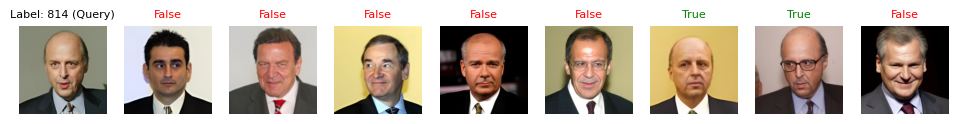

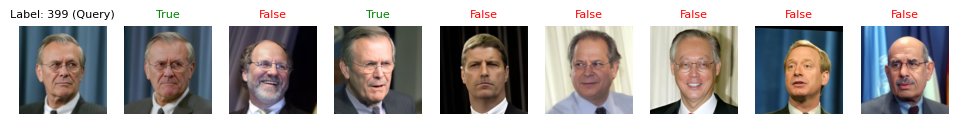

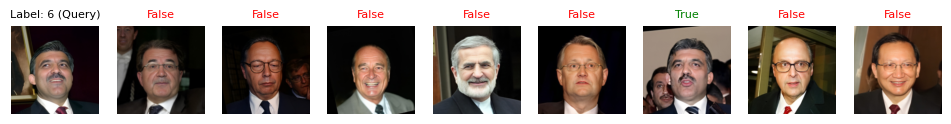

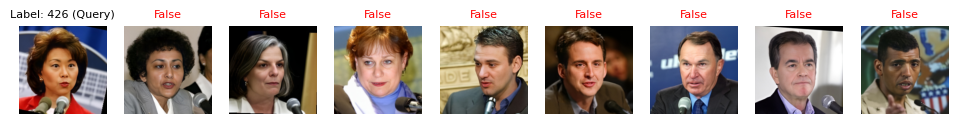

In [18]:
ranked_similar_samples_indices = pfe_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(pfe_images, pfe_labels, ranked_similar_samples_indices, samples, 8)


In [19]:
model = proxyanchor_model
loader = lfw_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  proxyanchor_labels = []
  proxyanchor_images = []
  proxyanchor_embeddings = []
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    proxyanchor_embeddings.append(model_output)
    proxyanchor_labels.append(y)
    proxyanchor_images.append(x)

  proxyanchor_embeddings = t.cat(proxyanchor_embeddings)
  proxyanchor_similarity_mat = F.linear(proxyanchor_embeddings, proxyanchor_embeddings).to(device)
  proxyanchor_labels = t.cat(proxyanchor_labels).cpu().numpy()
  proxyanchor_images = t.cat(proxyanchor_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:04<00:00, 54.85it/s]


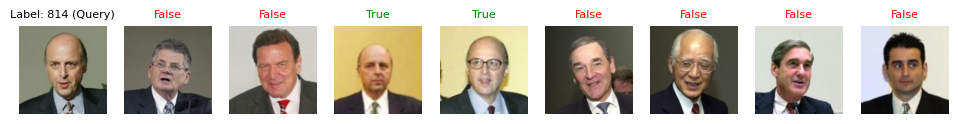

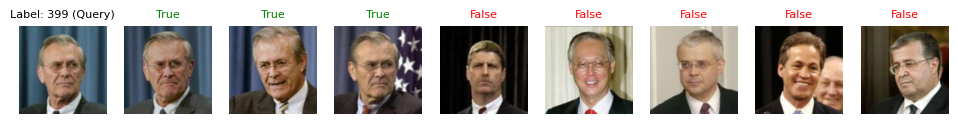

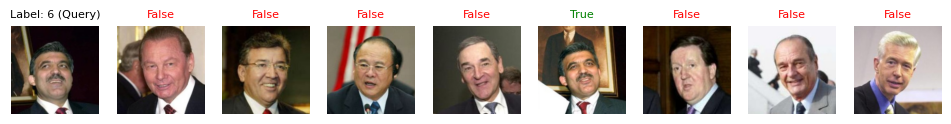

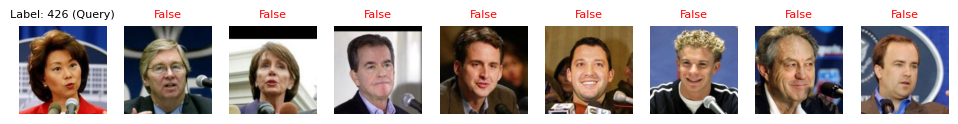

In [20]:
ranked_similar_samples_indices = proxyanchor_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(proxyanchor_images, proxyanchor_labels, ranked_similar_samples_indices, samples, 8)


In [21]:
model = proxyanchor_model
loader = lfw_gfpgan_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  proxyanchor_labels = []
  proxyanchor_images = []
  proxyanchor_embeddings = []
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    proxyanchor_embeddings.append(model_output)
    proxyanchor_labels.append(y)
    proxyanchor_images.append(x)

  proxyanchor_embeddings = t.cat(proxyanchor_embeddings)
  proxyanchor_similarity_mat = F.linear(proxyanchor_embeddings, proxyanchor_embeddings).to(device)
  proxyanchor_labels = t.cat(proxyanchor_labels).cpu().numpy()
  proxyanchor_images = t.cat(proxyanchor_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:07<00:00, 29.66it/s]


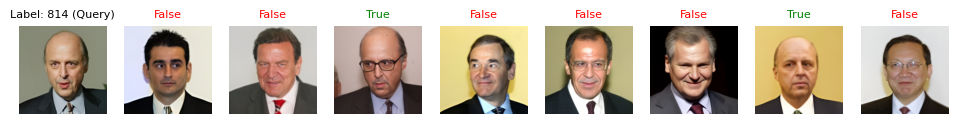

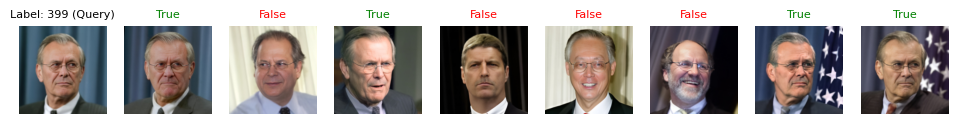

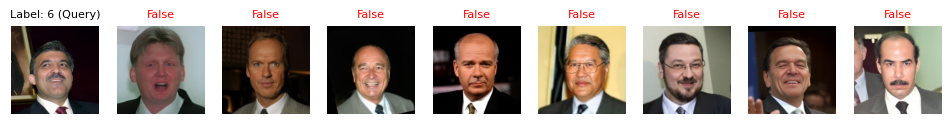

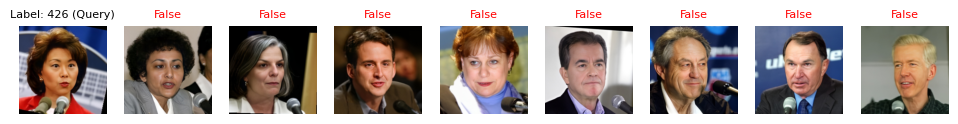

In [22]:
ranked_similar_samples_indices = proxyanchor_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(proxyanchor_images, proxyanchor_labels, ranked_similar_samples_indices, samples, 8)


In [23]:
model = proxype_model
loader = lfw_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  proxype_labels = []
  proxype_images = []
  proxype_embeddings = [[], []]
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    proxype_embeddings[0].append(model_output[0])  # mu
    proxype_embeddings[1].append(model_output[1])  # sig
    proxype_labels.append(y)
    proxype_images.append(x)

  proxype_embeddings = (t.cat(proxype_embeddings[0]), t.cat(proxype_embeddings[1]))
  proxype_similarity_mat = utils.compute_batch_mls(proxype_embeddings, proxype_embeddings, limit_memory=True)
  proxype_labels = t.cat(proxype_labels).cpu().numpy()
  proxype_images = t.cat(proxype_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:04<00:00, 53.71it/s]


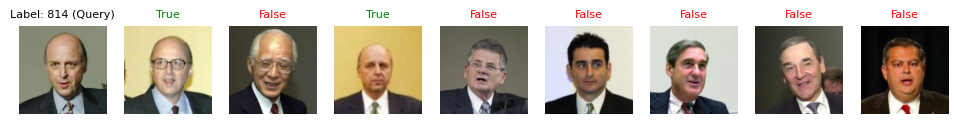

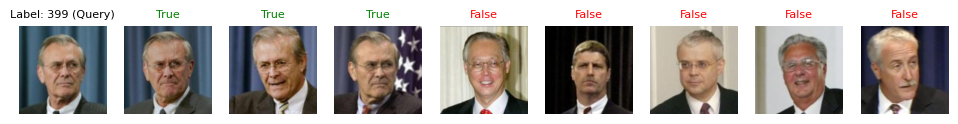

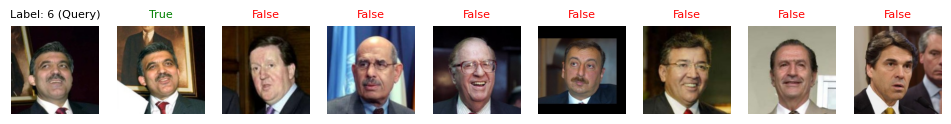

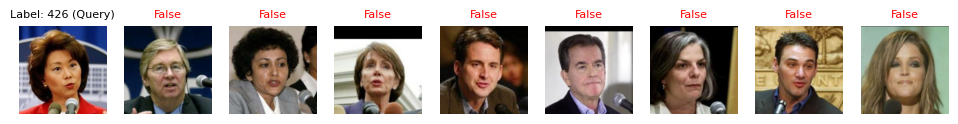

In [24]:
ranked_similar_samples_indices = proxype_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(proxype_images, proxype_labels, ranked_similar_samples_indices, samples, 8)


In [25]:
model = proxype_model
loader = lfw_gfpgan_unnormalized_tst_loader

model.train(False)
with t.no_grad():
  progress_bar = tqdm(enumerate(loader), total=len(loader))
  progress_bar.set_description(
      f'Evaluating'
  )
  proxype_labels = []
  proxype_images = []
  proxype_embeddings = [[], []]
  for _, (x_batch, y_batch) in progress_bar:
    x = x_batch.squeeze().to(device)
    model_output = model(x)
    y = y_batch.squeeze().to(device)

    proxype_embeddings[0].append(model_output[0])  # mu
    proxype_embeddings[1].append(model_output[1])  # sig
    proxype_labels.append(y)
    proxype_images.append(x)

  proxype_embeddings = (t.cat(proxype_embeddings[0]), t.cat(proxype_embeddings[1]))
  proxype_similarity_mat = utils.compute_batch_mls(proxype_embeddings, proxype_embeddings, limit_memory=True)
  proxype_labels = t.cat(proxype_labels).cpu().numpy()
  proxype_images = t.cat(proxype_images).cpu().numpy()


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:07<00:00, 31.08it/s]


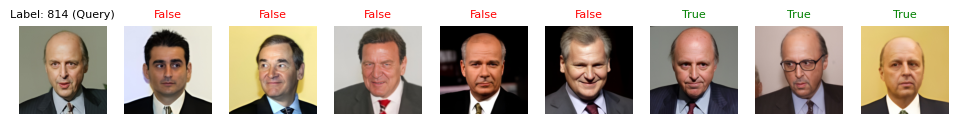

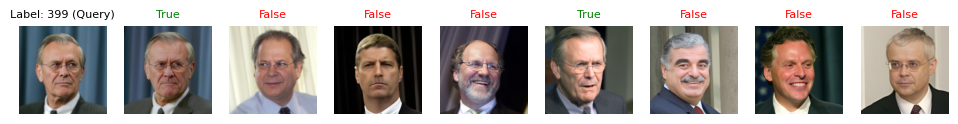

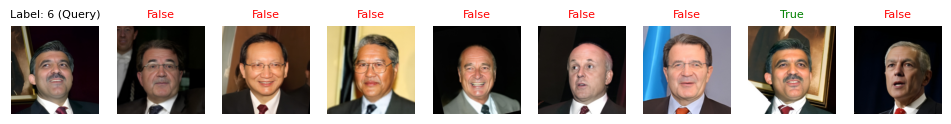

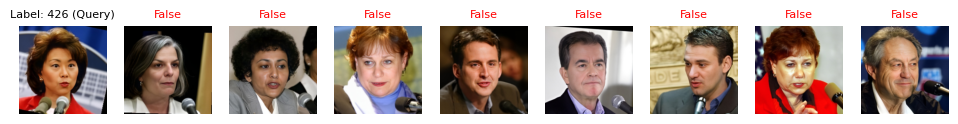

In [26]:
ranked_similar_samples_indices = proxype_similarity_mat.topk(k=33)[1][:, 1:].cpu().numpy()
visualize_topk_samples(proxype_images, proxype_labels, ranked_similar_samples_indices, samples, 8)


In [76]:
def tsne(model, loader):
  # Set model to evaluation mode
  model.train(False)
  with t.no_grad():
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    progress_bar.set_description(
        f'Visualizing t-SNE'
    )
    labels = []
    embeddings = []
    samples = 0
    for _, (x_batch, y_batch) in progress_bar:
      model_output = model(x_batch.squeeze().to(device))
      y = y_batch.squeeze().to(device)

      if isinstance(model_output, tuple):
        model_output = model_output[0]

      for mu, label in zip(model_output, y):
        if label in range(10):
          embeddings.append(mu)
          labels.append(label)
          samples += 1

    pos = t.stack(embeddings).cpu().numpy()
    labels = t.stack(labels).cpu().numpy()

    tsne = TSNE(n_components=2, random_state=1, n_iter=12000, learning_rate=10.0, metric='cosine', perplexity=np.min([samples - 1, 50]))
    embeddings_tsne = tsne.fit_transform(pos)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='tab10')
    print(range(len(np.unique(labels))))
    legend = plt.legend(handles=scatter.legend_elements()[0], labels=range(len(np.unique(labels))))
    plt.title('t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
